数据集总样本数: 608

=== 样本 0 (a45_12+.png) ===
XPL标签值范围: 0.0 - 4.0, 唯一值: [0. 2. 3. 4.]
PPL标签值范围: 0.0 - 4.0, 唯一值: [0. 2. 3. 4.]

=== 样本 1 (a45_2+.png) ===
XPL标签值范围: 0.0 - 4.0, 唯一值: [0. 1. 3. 4.]
PPL标签值范围: 0.0 - 4.0, 唯一值: [0. 1. 3. 4.]

=== 样本 2 (a35_13+.png) ===
XPL标签值范围: 0.0 - 4.0, 唯一值: [0. 1. 3. 4.]
PPL标签值范围: 0.0 - 4.0, 唯一值: [0. 1. 2. 3. 4.]


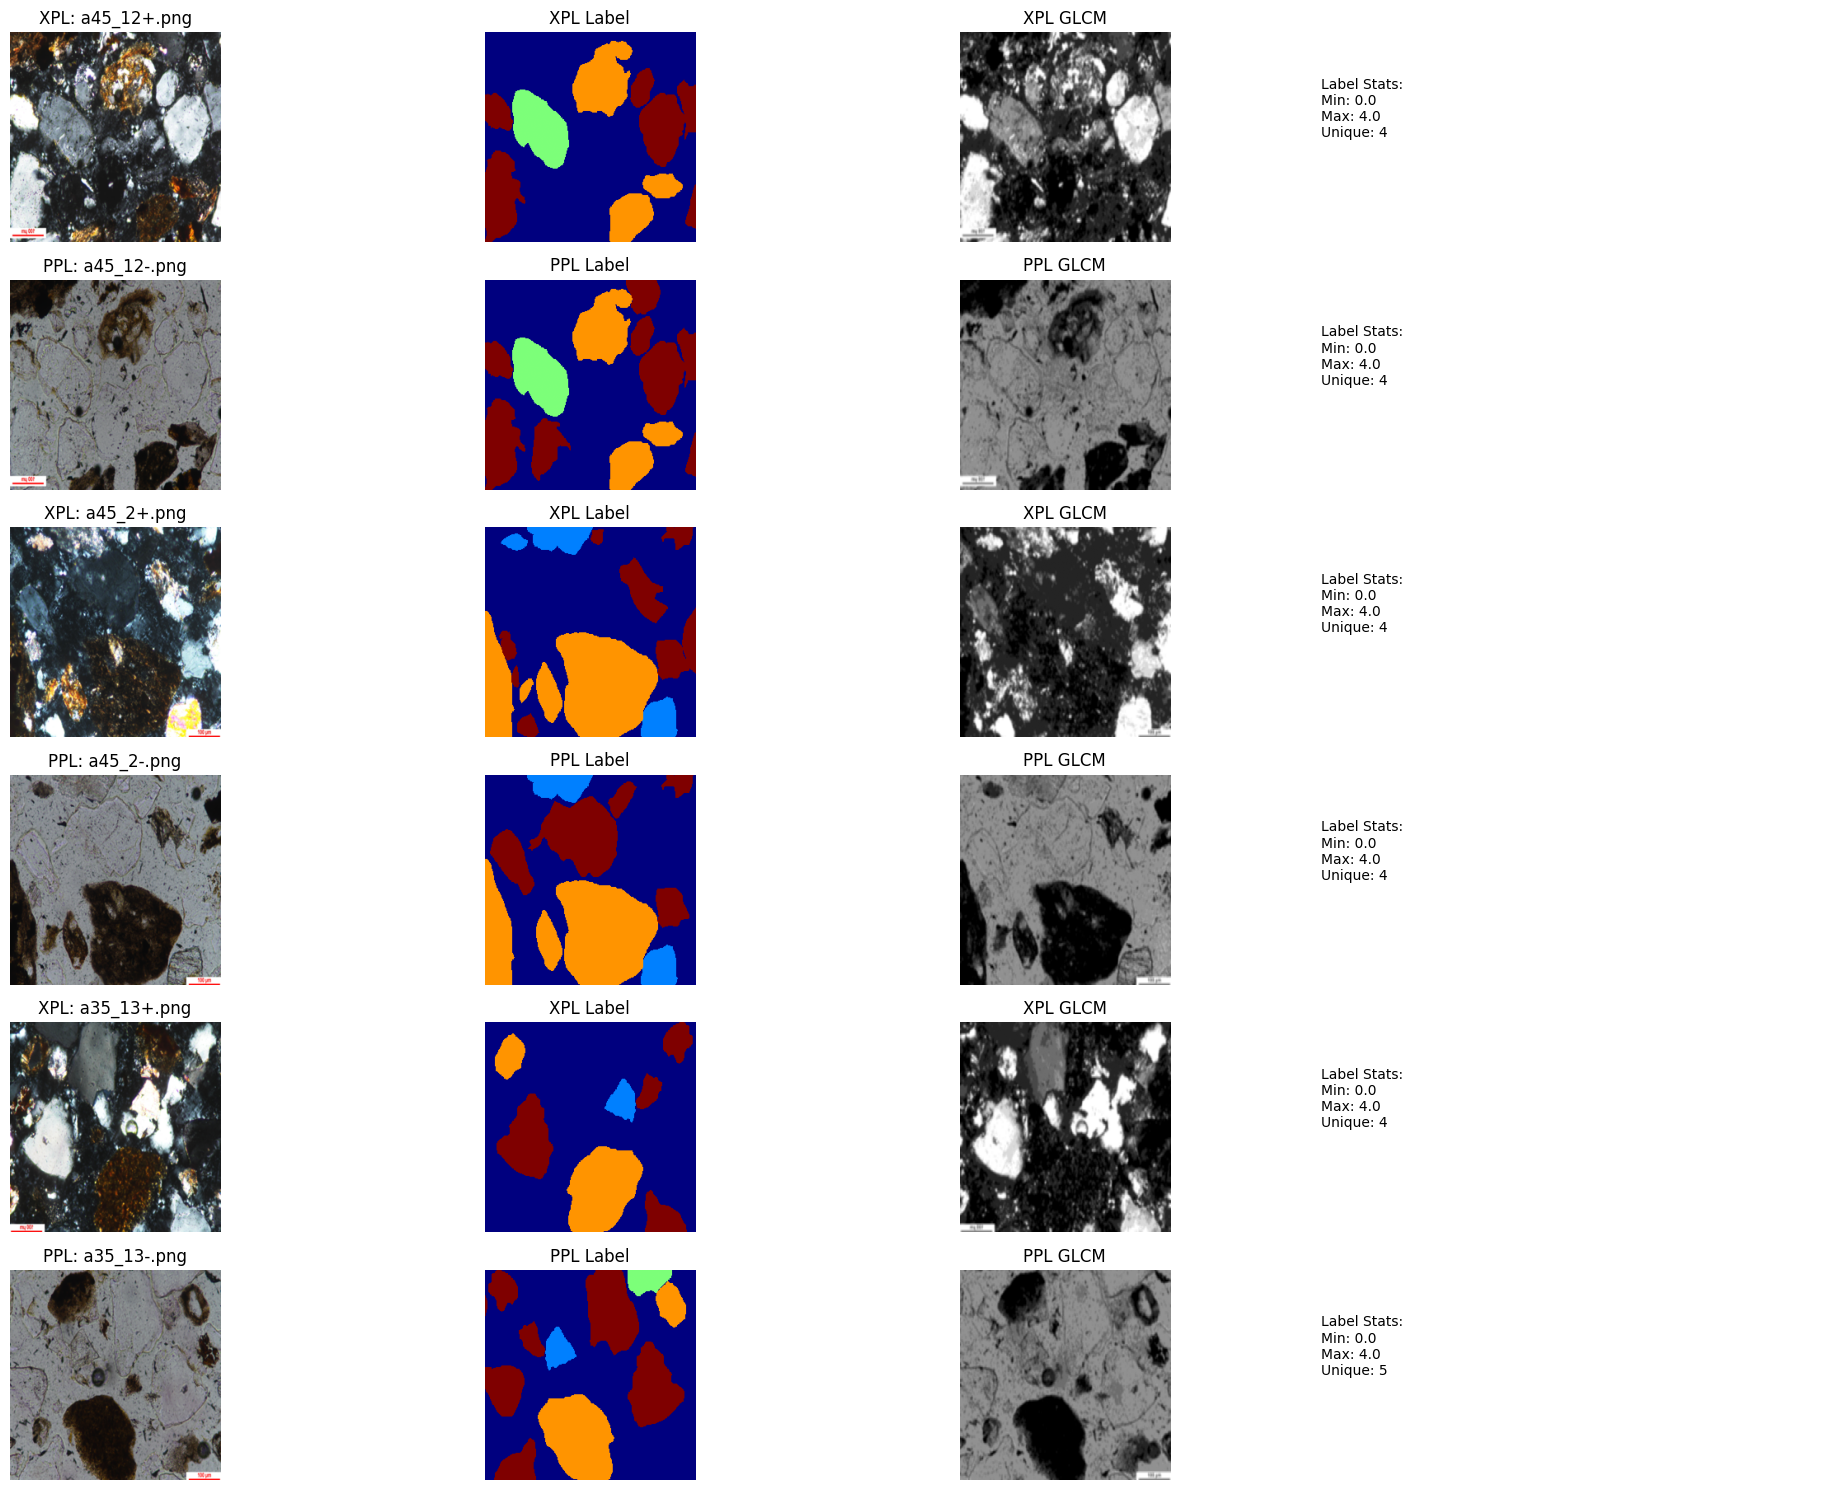

In [21]:
import random
import torch
import torch.utils.data
from torchvision import transforms as TR
import os
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, opt, for_metrics):
        opt.contain_dontcare_label = False
        opt.cache_filelist_read = False
        opt.cache_filelist_write = False
        opt.aspect_ratio = 1.0

        self.class_path = opt.class_dir
        with open(self.class_path, "r", encoding="utf-8") as f:
            cls = f.readlines()

        cls = cls[1:]
        self.class_dict = {}
        for c in cls:
            ls = c.split()
            self.class_dict[ls[0]] = ls[1]

        self.opt = opt
        self.for_metrics = for_metrics

        self.xpls, self.ppls, self.xpl_labels,self.ppl_labels, self.xpl_glcms, self.ppl_glcms, self.paths = self.list_images() # xpl, ppl, labels_xpl,labels_ppl, glcms_xpl,glcms_ppl, (path_img_xpl,path_img_ppl, path_lab)

    def __len__(self):
        return len(self.xpls)

    def __getitem__(self, idx):
        XPL = Image.open(self.xpls[idx]).convert('RGB')
        PPL = Image.open(self.ppls[idx]).convert('RGB')
        label_xpl = Image.open(self.xpl_labels[idx])
        label_ppl = Image.open(self.ppl_labels[idx])
        glcm_xpl = Image.open(self.xpl_glcms[idx])
        glcm_ppl = Image.open(self.ppl_glcms[idx])
        (XPL,PPL), (label_xpl,label_ppl), (glcm_xpl,glcm_ppl) = self.transforms((XPL,PPL), (label_xpl,label_ppl), (glcm_xpl,glcm_ppl))

        label_xpl = label_xpl * 255
        label_ppl = label_ppl * 255
        # 打印标签张量的像素值统计 
        name_xpl = os.path.basename(self.xpls[idx])
        name_ppl = os.path.basename(self.ppls[idx])
        # cls = torch.tensor(int(self.class_dict[filename]))
        return {"xpl": XPL,"ppl":PPL, "label_xpl": label_xpl,"label_ppl":label_ppl, "name_xpl": name_xpl,"name_ppl":name_ppl, "glcm_xpl": glcm_xpl,"glcm_ppl":glcm_ppl}#, 'class': cls}

    def list_images(self):
        mode = "test" if self.opt.phase == "test" or self.for_metrics else "train"
        # load image paths
        xpl = []
        path_img_xpl = os.path.join(self.opt.dataroot, mode + '_xpl')
        for city_folder in sorted(os.listdir(path_img_xpl)):
            item = os.path.join(path_img_xpl, city_folder)
            xpl.append(item)
        ppl = []
        path_img_ppl = os.path.join(self.opt.dataroot, mode + '_ppl')
        for city_folder in sorted(os.listdir(path_img_ppl)):
            item = os.path.join(path_img_ppl, city_folder)
            ppl.append(item)
        # load label paths
        labels_xpl = []
        path_lab = os.path.join(self.opt.dataroot, mode + '_label_xpl')
        for city_folder in sorted(os.listdir(path_lab)):
            item = os.path.join(path_lab, city_folder)
            labels_xpl.append(item)
        labels_ppl = []
        path_lab = os.path.join(self.opt.dataroot, mode + '_label_ppl')
        for city_folder in sorted(os.listdir(path_lab)):
            item = os.path.join(path_lab, city_folder)
            labels_ppl.append(item)
        # load glcm paths
        glcms_xpl = []
        path_canny = os.path.join(self.opt.dataroot, mode + '_glcm_xpl')
        for city_folder in sorted(os.listdir(path_canny)):
            item = os.path.join(path_canny, city_folder)
            glcms_xpl.append(item)
        glcms_ppl = []
        path_canny = os.path.join(self.opt.dataroot, mode + '_glcm_ppl')
        for city_folder in sorted(os.listdir(path_canny)):
            item = os.path.join(path_canny, city_folder)
            glcms_ppl.append(item)

        assert len(xpl)+len(ppl) == len(labels_xpl)+len(labels_ppl), "different len of images and labels %s - %s" % (len(xpl)+len(ppl), len(labels_xpl)+len(labels_ppl))

        return xpl,ppl, labels_xpl,labels_ppl, glcms_xpl,glcms_ppl, (path_img_xpl,path_img_ppl, path_lab)

    def transforms(self, images, labels, glcms):
        outimages=[]
        outlabels=[]
        outglcms=[]
        for i in range(len(images)):
            image= images[i]
            label = labels[i]
            glcm = glcms[i]
            assert image.size == label.size
            # resize
            new_width, new_height = (int(self.opt.load_size / self.opt.aspect_ratio), self.opt.load_size)
            image = TR.functional.resize(image, (new_width, new_height), Image.BICUBIC)
            label = TR.functional.resize(label, (new_width, new_height), Image.NEAREST)
            glcm = TR.functional.resize(glcm, (new_width, new_height), Image.NEAREST)
            # flip
            if not (self.opt.phase == "test" or self.opt.no_flip or self.for_metrics):
                if random.random() < 0.5:
                    image = TR.functional.hflip(image)
                    label = TR.functional.hflip(label)
                    glcm = TR.functional.hflip(glcm)
            
            # to tensor
            image = TR.functional.to_tensor(image)
            label = TR.functional.to_tensor(label)
            glcm = TR.functional.to_tensor(glcm)
            
            # normalize
            image = TR.functional.normalize(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            outimages.append(image)
            outlabels.append(label)
            outglcms.append(glcm)
        return outimages, outlabels, outglcms
    
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

def visualize_dual_dataset(dataset, num_samples=3):
    """
    可视化双模态数据集中的样本 (XPL/PPL)
    
    参数:
        dataset: CustomDataset 实例
        num_samples: 要显示的样本数量
    """
    # 随机选择样本
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # 创建画布 (每个样本占两行：XPL和PPL)
    fig, axs = plt.subplots(num_samples*2, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axs = axs.reshape(2, -1)  # 处理只显示一个样本的情况
    
    for i, idx in enumerate(indices):
        # 获取样本
        sample = dataset[idx]
        
        # XPL 数据
        xpl = (sample['xpl'].numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # 反归一化
        label_xpl = sample['label_xpl'].squeeze().numpy()
        glcm_xpl = sample['glcm_xpl'].squeeze().numpy()
        
        # PPL 数据
        ppl = (sample['ppl'].numpy().transpose(1, 2, 0) * 0.5 + 0.5)
        label_ppl = sample['label_ppl'].squeeze().numpy()
        glcm_ppl = sample['glcm_ppl'].squeeze().numpy()
        
        # 打印信息
        print(f"\n=== 样本 {i} ({sample['name_xpl']}) ===")
        print(f"XPL标签值范围: {label_xpl.min()} - {label_xpl.max()}, 唯一值: {np.unique(label_xpl)}")
        print(f"PPL标签值范围: {label_ppl.min()} - {label_ppl.max()}, 唯一值: {np.unique(label_ppl)}")
        
        # 显示XPL模态
        row = i*2
        axs[row, 0].imshow(xpl)
        axs[row, 0].set_title(f'XPL: {sample["name_xpl"]}')
        axs[row, 0].axis('off')
        
        axs[row, 1].imshow(label_xpl, cmap='jet', vmin=0, vmax=4)
        axs[row, 1].set_title('XPL Label')
        axs[row, 1].axis('off')
        
        axs[row, 2].imshow(glcm_xpl, cmap='gray')
        axs[row, 2].set_title('XPL GLCM')
        axs[row, 2].axis('off')
        
        # 显示标签统计
        axs[row, 3].text(0.1, 0.5, 
                        f"Label Stats:\nMin: {label_xpl.min()}\nMax: {label_xpl.max()}\n"
                        f"Unique: {len(np.unique(label_xpl))}",
                        fontsize=10)
        axs[row, 3].axis('off')
        
        # 显示PPL模态
        row = i*2 + 1
        axs[row, 0].imshow(ppl)
        axs[row, 0].set_title(f'PPL: {sample["name_ppl"]}')
        axs[row, 0].axis('off')
        
        axs[row, 1].imshow(label_ppl, cmap='jet', vmin=0, vmax=4)
        axs[row, 1].set_title('PPL Label')
        axs[row, 1].axis('off')
        
        axs[row, 2].imshow(glcm_ppl, cmap='gray')
        axs[row, 2].set_title('PPL GLCM')
        axs[row, 2].axis('off')
        
        # 显示标签统计
        axs[row, 3].text(0.1, 0.5, 
                        f"Label Stats:\nMin: {label_ppl.min()}\nMax: {label_ppl.max()}\n"
                        f"Unique: {len(np.unique(label_ppl))}",
                        fontsize=10)
        axs[row, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# 测试代码
if __name__ == "__main__":
    import types
    
    # 配置参数
    opt = types.SimpleNamespace()
    opt.phase = "train"
    opt.dataroot = r"/mnt/windows_F/wyj_project/PetroSynthGAN/datasets/rock"  # 修改为你的路径
    opt.class_dir = r"/mnt/windows_F/wyj_project/PetroSynthGAN/datasets/rock/class.txt"    # 修改为你的路径
    opt.load_size = 256
    opt.no_flip = False
    opt.aspect_ratio = 1.0
    
    # 创建数据集
    dataset = CustomDataset(opt, for_metrics=False)
    print(f"数据集总样本数: {len(dataset)}")
    
    # 可视化3个样本
    visualize_dual_dataset(dataset, num_samples=3)